<a href="https://colab.research.google.com/github/francotestori/aauba_01/blob/master/decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje Automático
## Trabajo Práctico 1

El objetivo de este trabajo práctico es el desarrollo de una solución que permita predecir la cancelación de una reserva utilizando como dataset el archivo provisto por la catedra ***'hotel_bookins.csv'***.

In [0]:
# Cargar el archivo original de bookings
!wget https://raw.githubusercontent.com/francotestori/aauba_01/master/resources/hotel_bookings.csv

In [0]:
# Utilizar pandas para hacer la carga del dataframe de bookings
import pandas as pd

pd.set_option('display.max_columns', 35)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 10000)

bookings_df = pd.read_csv('hotel_bookings.csv')
bookings_df.head()

## a. Descripción de los atributos

---

### a.i. Campos categóricos
Pertenecen a este grupo los campos numéricos o no cuyos valores representen categorías en las que la reserva de hoteles se asignará, siempre y cuando estas categorías no puedan ordenarse en forma inmediata. Pertenecen a este grupo los campos que pueden tomar valores 0 y 1, entre otros. Se agregan también el campo AÑO y el campo MES, para que no tomen valores numéricos.

In [0]:
columnas_categoricas = [
  'hotel', 
  'is_canceled', 
  'meal', 
  'country', 
  'market_segment', 
  'distribution_channel', 
  'is_repeated_guest', 
  'deposit_type', 
  'agent', 
  'company', 
  'customer_type', 
  'reservation_status',
  'arrival_date_month'
]
df_categoricas = bookings_df[columnas_categoricas]
df_categoricas

Campos:

*   **hotel**: tipo de hotel (si es Resort o es City)
*   **is_cancelled**: variable que toma 1 cuando la reserva fue cancelada
*   **meal**: tipo de reserva elegida. FB (Full Board), HB (Half Board), SC (self-catering), BB (Bed & Breakfast). Esta variable toma valores indefinidos.
*   **country**: siglas del país de origen de quienes reservan.
*   **market_segment**: segmento de mercado.
*   **distribution_channel**: canal de distribución.
*   **is_repeated_guest**: variable que toma uno cuando se trata de una reserva repetida.
*   **deposit_type**: tipo de depósito, según su condición de reembolsable o no.
*   **agent**: código del agente responsable de la reserva.
*   **company**: código de la empresa responsable de la reserva.
*   **customer_type**: tipo de consumidor.
*   **customer_type**: estado actual de la reserva.


In [0]:
pd.set_option('display.max_rows', 1000)

for i in range(len(df_categoricas.columns)):
  print(df_categoricas[df_categoricas.columns[i]].value_counts())


### a.ii. Campos numéricos
Pertenecen a este grupo los campos numéricos continuos, cuyo valor represente una magnitud y no una categoría. En los casos 

In [0]:
columnas_numericas = [
    'lead_time',  
    'arrival_date_week_number', 
    'stays_in_weekend_nights', 
    'stays_in_weekend_nights', 
    'adults', 
    'children', 
    'babies', 
    'previous_cancellations', 
    'previous_bookings_not_canceled', 
    'booking_changes', 
    'days_in_waiting_list', 
    'adr', 
    'required_car_parking_spaces', 
    'total_of_special_requests'                      
]
df_numericas = bookings_df[columnas_numericas]
df_numericas

Campos:

*   **lead_time**: tiempo de espera desde la emisión hasta la confirmación de la orden.
*   **arrival_date_week_number**: semana del año en la que llegarán al hotel.
*   **stays_in_weekend_nights**: número de noches de fin de semana que se pasarán en el hotel.
*   **stays_in_week_nights**: número de noches de semana que se pasarán en el hotel.
*   **adults**: número de adultos que conforman la reserva.
*   **children**: número de niños que conforman la reserva.
*   **babies**: número de bebés que conforman la reserva.
*   **previous_cancellations**: número de reservas previas que fueron canceladas.
*   **previous_bookings_not_canceled**: número de reservas previas que no fueron canceladas.
*   **booking_changes**: número de cambios en la reserva.
*   **days_in_waiting_list**: número de días en lista de espera.
*   **adr**: tarifa media diaria.
*   **required_car_parking_spaces**: número de espacios para estacionar requeridos.
*   **total_of_special_requests**: total de pedidos especiales.

### ai.iii. Campos ordinales
Pertenecen a este grupo las variables numéricas o no que son categorías (no pueden tomar cualquier valor) pero de las que es posible establecer un orden.

In [0]:
columnas_ordinales = [
       'reserved_room_type', 
       'assigned_room_type'               
]
df_ordinales = bookings_df[columnas_ordinales]
df_ordinales

Campos:

*   **reserved_room_type**: tipo de habitación reservada.
*   **assigned_room_type**: tipo de habitación asignada.

In [0]:
ordinales = df_ordinales.apply(lambda x: x.value_counts()).T.stack()
ordinales

### ai.iii. Campos fecha/hora

Estos campos son aquellos que hacen referencia a fechas y horas. Algunos estan expresados en varias columnas(variables categóricas y numéricas) y en formato ISO (arrival/check-in).

En cambio el dato reservatin_status_date (ultima fecha de cambio de status de una reserva) está expresado como una fecha Gregoriana.

Veremos de normalizar estos campos para luego permitirnos hacer un análisis mas profundo.

In [0]:
from datetime import date, datetime

def get_month_number(month):
  if month == "January":
    return 1
  elif month == "February":
    return 2   
  elif month == "March":
    return 3   
  elif month == "April":
    return 4   
  elif month == "May":
    return 5   
  elif month == "June":
    return 6   
  elif month == "July":
    return 7   
  elif month == "August":
    return 8   
  elif month == "September":
    return 9   
  elif month == "October":
    return 10
  elif month == "November":
    return 11   
  elif month == "December":
    return 12
  else:
    return 0     

def checkin(year, month_str, day):
  month = get_month_number(month_str)
  return date(year, month, day)

In [0]:
columnas_fecha_hora = [
  'arrival_date_month', 
  'arrival_date_year',
  'arrival_date_day_of_month',   
  'reservation_status_date'               
]
df_fecha_hora = bookings_df[columnas_fecha_hora]
df_fecha_hora['checkin_date'] = df_fecha_hora.apply(
    lambda x: checkin(x['arrival_date_year'], x['arrival_date_month'], x['arrival_date_day_of_month']),
    axis=1
)

Campos:

*   **arrival_date_day_of_month**: día del mes en el que llegarán al hotel.
*   **arrival_date_year**: año de arribo al hotel.
*   **arrival_date_month**: mes de arribo al hotel.
*   **reservation_status_date**: fecha de ultimo status de la reserva.

## b. Valores faltantes

In [0]:
bookings_df.isnull().sum()

Contamos con faltantes en los siguientes atributos:
* children: Son muy pocos casos, 4. 
* country: Pocos casos sería posible con alguna medida de cercanía.
* agent: Relativamente grande número de faltantes, 15%.
* company: Número demasiado grande de faltantes, aprox 90%.

Es posible imputar el valor más común del atributo, el más común de la clasificación o asignar una probabilidad en base a las frecuencias observadas(este último no lo encuentro muy aplicable).

##### Estrategias relleno
* children: valor más común. 
* country: asignar valor por fuera del rango conocido (ejemplo: 'XXX').
* agent: asignar valor por fuera del rango conocido.
* company: utilizar una máscara que determine presencia del campo.


##### Aplico estrategias
Analizo las modas de los atributos

In [0]:
bookings_df.mode()

In [0]:
bookings_df['children'].fillna(0.0, inplace = True)
bookings_df['country'].fillna('XXX', inplace = True)
bookings_df['has_agent'] = bookings_df['agent'].isnull()
bookings_df['has_company'] = bookings_df['company'].isnull()

bookings_df.isnull().sum()

## c. Variables correlacionadas


### c.i. Análisis general
Iniciamos con un análisis general del dataframe

In [0]:
corr = bookings_df.corr()
abs(corr.iloc[0,]).sort_values(ascending=False).head

Las cuatro variables más correlacionadas son:

* **lead_time**                      0.293123
* **total_of_special_requests**      0.234658
* **required_car_parking_spaces**    0.195498
* **booking_changes**                0.144381

### c.i. Cuantificación de Variables categóricas
Luego probamos de hacer un análisis cuantificando las variables categóricas.

In [0]:
def quantify_room_type(room_type):
    if room_type == 'A':
        return 1
    elif room_type == 'B':
        return 2
    elif room_type == 'C':
        return 3
    elif room_type == 'D':
        return 4
    elif room_type == 'E':
        return 5
    elif room_type == 'F':
        return 6
    elif room_type == 'G':
        return 7
    elif room_type == 'H':
        return 8
    elif room_type == 'I':
        return 9
    elif room_type == 'K':
        return 10
    elif room_type == 'L':
        return 11
    elif room_type == 'P':
        return 12
    else:
        return 0

def room_matches(this_room, other_room):
  match = this_room.lower().replace('s/+',"") == other_room.lower().replace('s/+',"")
  if(match):
    return 1
  else:
    return 0

Asignamos dummies a las variables que no cuantificamos previamente como room_types y month.
Además previamente ya tenemos registrados que company y agent las usamos como dummies de está presente o no está presente.

In [63]:
# 1. Para las categóricas, construyo variables 0 y 1
  # Mínimo de frecuencia para incluir la columna: 0.5% del total
min_dummy = len(df_categoricas)*0.005

# Evitamos incluir company y agent ya que las vamos a utilizar con el 
# has_company y has_agent
df_categoricas['has_agent'] = bookings_df['agent'].isnull().astype(int)
df_categoricas['has_company'] = bookings_df['company'].isnull().astype(int)

dummies_cat = pd.get_dummies(
    df_categoricas, 
    columns=[
      'hotel',       
      'market_segment', 
      'meal', 
      'is_repeated_guest', 
      'deposit_type', 
      'customer_type' 
    ], 
    drop_first=False
)
dummies_cat = dummies_cat.iloc[:, 8:]
corr_cat = dummies_cat[dummies_cat.columns[dummies_cat.sum()>min_dummy]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Ahora hacemos un transformación similar para nuestras variables ordinales

In [64]:
### 2. Para las ordinales, puedo construir variables numéricas asociadas. 
### Como una es el tipo de habitación pedido y otro es el tipo de habitación asignado, 
### voy a construir únicamente la numérica asociada al tipo de habitación asignado, 
### y luego voy a construir una columna dummy si el tipo de habitación pedida es el mismo o no que la asignada.
df_ordinales['assigned_room_vl'] = df_ordinales.apply(lambda x: quantify_room_type(x['assigned_room_type']), axis=1)
df_ordinales['requested_room_vl'] = df_ordinales.apply(lambda x: quantify_room_type(x['reserved_room_type']), axis=1)
df_ordinales['did_room_match'] = df_ordinales.apply(lambda x: room_matches(x['reserved_room_type'],x['assigned_room_type']), axis=1)
df_ordinales['booker_room_gain'] = df_ordinales.apply(lambda x: x['assigned_room_vl'] - x['requested_room_vl'], axis=1)

corr_ord = df_ordinales[['assigned_room_vl', 'requested_room_vl','did_room_match', 'booker_room_gain']]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [0]:
# 3. Para las numéricas traigo todas

corr_num = df_numericas

Ahora junto todo y calculo las correlaciones

In [66]:
df_correlations = pd.concat([corr_num,corr_ord,corr_cat],axis=1)
df_correlations
df_correlations.loc[:,'is_canceled'] = df_categoricas['is_canceled'] 
corr = df_correlations[df_correlations.columns].corr()['is_canceled'][:-1]
squaredCorrs = corr**2 # Elevo al cuadrado para quedarme con las primeras
squaredCorrs.sort_values(ascending=False)

deposit_type_Non Refund           0.231801
deposit_type_No Deposit           0.228399
lead_time                         0.085921
did_room_match                    0.061390
total_of_special_requests         0.055064
market_segment_Groups             0.049222
booker_room_gain                  0.042224
required_car_parking_spaces       0.038219
assigned_room_vl                  0.030986
market_segment_Direct             0.023836
booking_changes                   0.020846
hotel_City Hotel                  0.018641
hotel_Resort Hotel                0.018641
customer_type_Transient           0.017711
customer_type_Transient-Party     0.015409
previous_cancellations            0.012129
has_company                       0.009862
is_repeated_guest_1               0.007190
is_repeated_guest_0               0.007190
market_segment_Corporate          0.006669
requested_room_vl                 0.003730
adults                            0.003602
previous_bookings_not_canceled    0.003290
days_in_wai

Me quedo con las primeras cuatro

In [0]:
#import matplotlib.pyplot as plt
#import numpy as np

df_first4 = df_correlations[
    [
     'deposit_type_Non Refund', 
     'deposit_type_No Deposit', 
     'lead_time', 
     'did_room_match', 
     'is_canceled']
    ]

matriz_nonRefund = pd.crosstab(df_correlations['deposit_type_Non Refund'], bookings_df['is_canceled'], rownames=['Tipo de depósito Non Refund'], colnames=['Cancelacion'])
matriz_noDeposit = pd.crosstab(df_correlations['deposit_type_No Deposit'], bookings_df['is_canceled'], rownames=['Tipo de depósito No Deposit'], colnames=['Cancelacion'])
matriz_roomMatch = pd.crosstab(df_correlations['did_room_match'], bookings_df['is_canceled'], rownames=['Se les asignó lo que solicitaron'], colnames=['Cancelacion'])
matriz_leadTime = pd.crosstab(df_correlations['lead_time'], bookings_df['is_canceled'], rownames=['Lead Time'], colnames=['Cancelacion'])


## d. Atributos a emplear como variables predictoras para cancelación, con antelación.

(Fede)

Las variables de mayor correlación que tenemos con antelación son:
* **deposit_type_Non Refund** 0.231801
* **deposit_type_Non Deposit** 0.228399
* **lead_time** 0.085921
* **did_room_match** 0.061390
* **total_of_special_requests** 0.055064

(Nico)

Las variables de mayor correlación que tenemos con antelación son:
* **lead_time**                      0.293123
* **total_of_special_requests**      0.234658
* **required_car_parking_spaces**    0.195498
* **previous_cancellations**         0.110133
* **is_repeated_guest**              0.084793


La siguiente variable podríamos no tener información completa hasta que llegue el momento de check-in
* **booking_changes**                0.144381

In [0]:
pip install info_gain

In [0]:
from info_gain import info_gain
ig=pd.DataFrame(columns=['Atributo', 'Information Gain ratio'])
for i in range(len(bookings_df.columns)):
  print(bookings_df.columns[i],info_gain.info_gain_ratio(bookings_df.iloc[0:31,1],bookings_df.iloc[0:31,i]))  
  ig.iloc[i] = [bookings_df.columns[i]] + [info_gain.info_gain_ratio(bookings_df.iloc[0:31,1],bookings_df.iloc[0:31,i])]

In [0]:
ig=pd.DataFrame(columns=['Atributo', 'Information Gain ratio'])
ig.append(['1','10'])
print(ig)

## e. Se encuentra balanceado el set
Hay casi el doble de reservas no canceladas frente a las canceladas.

Todavía no lo vimos en clase.


In [27]:
# Buscamos conocer que tan balanceado está nuestro dataset
bookings_df['is_canceled'].value_counts(normalize=True)

0    0.629584
1    0.370416
Name: is_canceled, dtype: float64

## g. Implementación Árbol de decisión
Implementaremos la lógica algoritmica que nos permita armar los árboles de decisión de forma programática
Recordemos que nuestra solución debe analizar los datos acordes al criterio de **RESERVA CANCELADA**

#### Armado y Ejecución

In [0]:
features = df_correlations.columns
for feature in features:
  print(feature)

In [0]:
#Con sklearn podemos dividir nuestros datos en conjuntos de entrenamiento, validación y prueba.

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Para el análisis deberiamos utilizar un DF con las variables dummies cargadas
# Lo unico que tengo dudas es si en features no hay que dropear la columna 'is_canceled'
features = df_correlations.columns
target = 'is_canceled'

# Armamos 2 sets de datos
# X (tanto train como)
x_train, x_test, y_train, y_test = train_test_split(
    df_correlations[features].values, 
    df_correlations[target].values, 
    test_size=0.2, 
    random_state=42
)

x_val, x_test, y_val, y_test = train_test_split(
    x_test,
    y_test,
    test_size=0.2
)

In [0]:
print('Entrenamiento: {}'.format(len(x_train)))
print('Validacion: {}'.format(len(x_val)))
print('Prueba: {}'.format(len(x_test)))

In [0]:
# hacemos n_seeds particiones para entrenar nuestro algoritmo
n_seeds = 100
accs = []
precisions = []
recalls = []
f1s = []

for seed in range(n_seeds):
  # Arbol de decisión
  arbol_sklearn = DecisionTreeClassifier(
      criterion='entropy',
      max_depth=5,
      min_samples_leaf=10, 
      ccp_alpha=0.01
  )
  # División train-validation (requiere x_train y y_train previos)
  x_train_, x_val, y_train_, y_val = train_test_split(
      x_train, 
      y_train, 
      test_size=0.2, 
      random_state=seed,
      stratify=y_train
  )
  # Entrenamos al arbol
  arbol_sklearn.fit(x_train_,y_train_)

  # Ejecutamos nuestra predicción
  y_pred_val = arbol_sklearn.predict(x_val)

  # Medimos (accuracy, precision, recall y f1Score) de nuestra predicción
  accs.append(accuracy_score(y_val,y_pred_val))
  precisions.append(precision_score(y_val,y_pred_val))
  recalls.append(recall_score(y_val,y_pred_val))
  f1s.append(f1_score(y_val,y_pred_val))

In [0]:
# Visualizamos la performance de nuestro arbol
all_metrics = accs + precisions + recalls + f1s
metric_labels = ['Accuracy']*len(accs) + ['Precision']*len(precisions) + ['Recall']*len(recalls) + ['F1 Score']*len(f1s)

sns.set_context('talk')
plt.figure(figsize=(15,8))
sns.boxplot(metric_labels,all_metrics)

In [0]:
# Visualizamos como quedó nuestro arbol
plt.figure(figsize=(20,10))
plot_tree(arbol_sklearn,filled=True);

#### Búsqueda de Hiperparámetros y Cross-Validation

In [0]:
# Para validar hiperparámetros (profundidad, función de costo, numero de hojas)
# Aplicamos K-fold validation para analizar y comparar las distintas combinaciones de hiperparámetros
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
import numpy as np

params_grid = {'criterion':['gini','entropy'],
               'max_depth':list(range(1,30)),
               'ccp_alpha':np.linspace(0,0.5,100)}

kfoldcv = StratifiedKFold(n_splits=10)
base_tree = DecisionTreeClassifier()
scorer_fn = make_scorer(f1_score)
randomcv = RandomizedSearchCV(
    estimator=base_tree,
    param_distributions = params_grid,
    scoring=scorer_fn,
    cv=kfoldcv,
    n_iter=100
)
randomcv.fit(x_train,y_train);

In [0]:
# Ver combinaciones
pd.DataFrame(randomcv.cv_results_).head()

In [0]:
# Ver cuál fue la mejor
randomcv.best_params_

In [0]:
# Vemos el nivel de importancia de cada parametro en el arbol entrenado
best_tree = randomcv.best_estimator_
feat_imps = best_tree.feature_importances_
feat_imps

In [0]:
# Vemos que parámetro uso el árbol para tomar decisiones (importancia mayor a 0)
for feat_imp,feat in sorted(zip(feat_imps,features)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

#### Métricas de Arbol Predictor

# Extras & Ayuda Gráfica


In [0]:
# Macros para ayudar a graficar distintos datos
from palettable.colorbrewer.qualitative import Pastel1_9
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns

def plot_donut(dataframe, column, title):
  donut = plt.Circle( (0,0), 0.7, color='white')

  data = dataframe[column].value_counts(normalize=True)
  labels = data.index.values.tolist()
  legend_labels = ['%s - %2.2f %%' % (l, s*100) for l, s in zip(labels, data)]

  plt.title(title)
  plt.gca().axis("equal")
  plt.gca().add_artist(donut)
  plt.pie(
    data, 
    startangle=90, 
    colors=Pastel1_9.hex_colors,
    wedgeprops = { 'linewidth': 2, "edgecolor" :"white" }
  )

  handles = []
  for i, l in enumerate(labels):
      handles.append(matplotlib.patches.Patch(color=Pastel1_9.hex_colors[i], label=l))
  
  plt.legend(handles,legend_labels, bbox_to_anchor=(0.85,1.025), loc="upper left")
  plt.subplots_adjust(left=0.1, bottom=0.1, right=0.75)
  plt.show()

def plot_bar_counts(dataframe, column, title):
  data = dataframe[column].value_counts()
  labels = data.index.values.tolist()
  legend_labels = ['%s - %s' % (l, s) for l, s in zip(labels, data)]

  y_pos = np.arange(len(labels))

  plt.bar(y_pos, data)

  plt.xticks(y_pos, legend_labels, color='orange')
  plt.yticks(color='orange')

  plt.show()

def histogram(dataframe, column, title):
  f, (ax_box, ax_hist) = plt.subplots(
    2, 
    sharex=True, 
    gridspec_kw={"height_ratios": (.15, .85)}
  )

  # Add a graph in each part
  sns.boxplot(dataframe[column], ax=ax_box)
  sns.distplot(dataframe[column], ax=ax_hist)
  
  # Remove x axis name for the boxplot
  ax_box.set(xlabel='')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Segmentación Reservas Canceladas & Confirmadas

In [0]:
# Segmentar en canceladas & confirmadas
canceled_df = bookings_df[bookings_df['is_canceled'] == 1]
confirmed_df = bookings_df[bookings_df['is_canceled'] == 0]

## Gráficos

### Status de las reservas

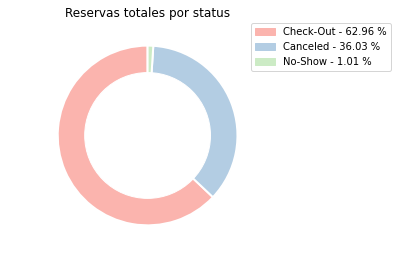

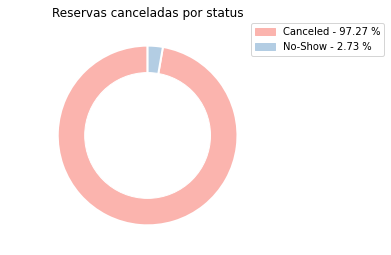

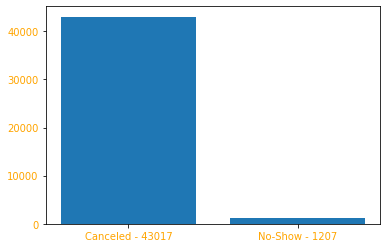

In [0]:
import numpy as np
# Status de reservas
plot_donut(bookings_df, 'reservation_status', 'Reservas totales por status')
plot_donut(canceled_df, 'reservation_status', 'Reservas canceladas por status')

plot_bar_counts(canceled_df, 'reservation_status', 'Reservas canceladas por status')


### Reservas por Tipo de Hotel

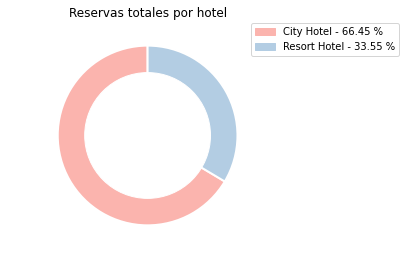

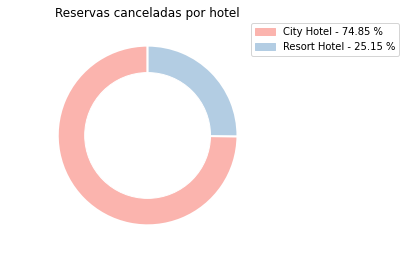

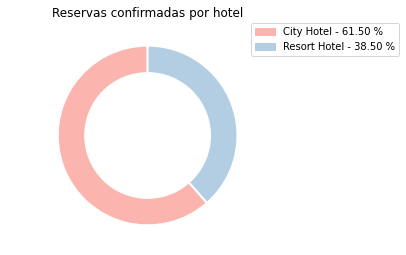

In [0]:
# Tipo de hotel por reservas 
plot_donut(bookings_df, 'hotel', 'Reservas totales por hotel')
plot_donut(canceled_df, 'hotel', 'Reservas canceladas por hotel')
plot_donut(confirmed_df, 'hotel', 'Reservas confirmadas por hotel')

### Reservas por Tipo de Cliente

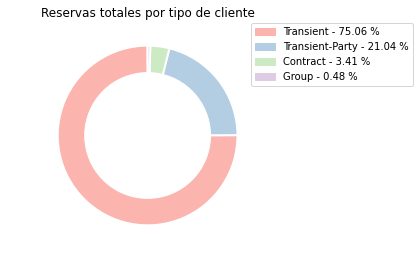

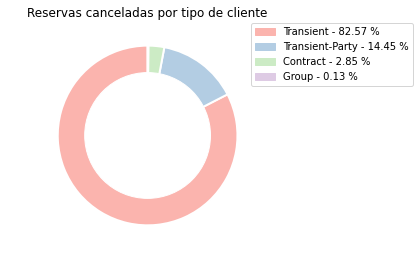

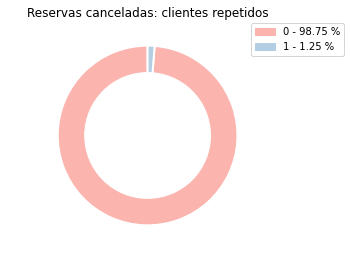

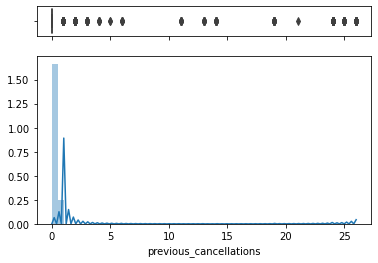

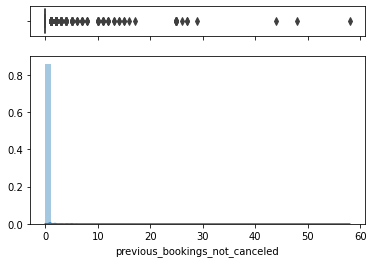

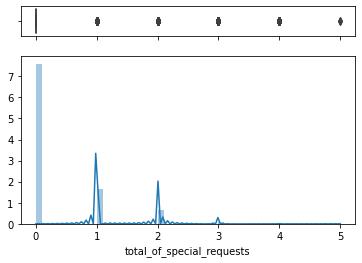

In [0]:
# Tipo de cliente de reservas
plot_donut(bookings_df, 'customer_type', 'Reservas totales por tipo de cliente')
plot_donut(canceled_df, 'customer_type', 'Reservas canceladas por tipo de cliente')


plot_donut(canceled_df, 'is_repeated_guest', 'Reservas canceladas: clientes repetidos')

histogram(canceled_df, 'previous_cancellations', 'Reservas canceladas: cancelaciones previas')
histogram(canceled_df, 'previous_bookings_not_canceled', 'Reservas canceladas: confirmaciones previas a la primer cancelación')
histogram(canceled_df, 'total_of_special_requests', 'Reservas canceladas: pedidos extras')




### Segmento de Mercado y Canales de Distribución

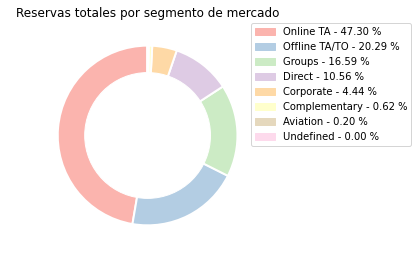

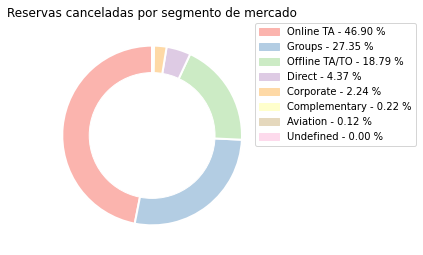

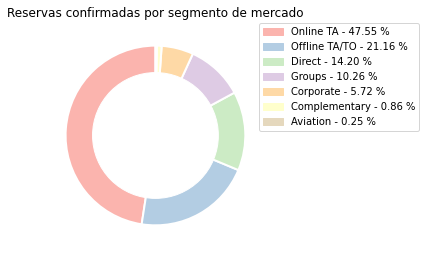

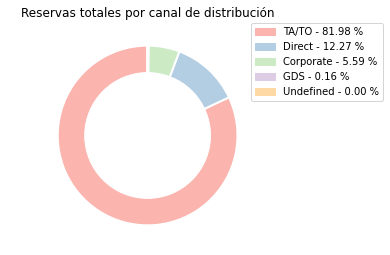

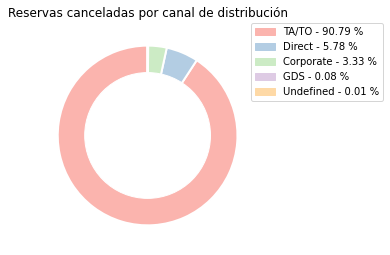

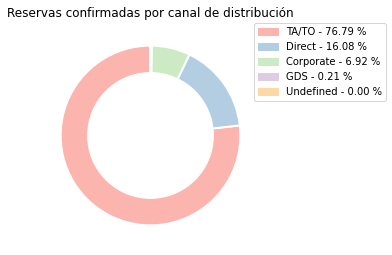

In [0]:
# Segmento de mercado de reservas
plot_donut(bookings_df, 'market_segment', 'Reservas totales por segmento de mercado')
plot_donut(canceled_df, 'market_segment', 'Reservas canceladas por segmento de mercado')
plot_donut(confirmed_df, 'market_segment', 'Reservas confirmadas por segmento de mercado')

# canal de distribución de reservas
plot_donut(bookings_df, 'distribution_channel', 'Reservas totales por canal de distribución')
plot_donut(canceled_df, 'distribution_channel', 'Reservas canceladas por canal de distribución')
plot_donut(confirmed_df, 'distribution_channel', 'Reservas confirmadas por canal de distribución')

### Tipo de Depósito

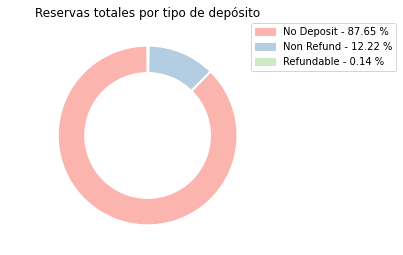

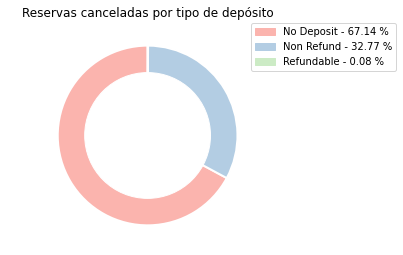

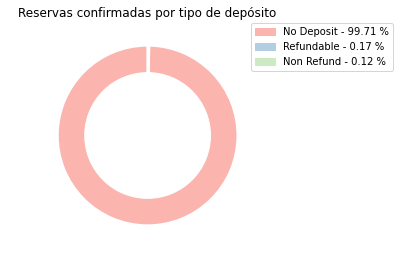

In [0]:
# Tipo de Depósito
plot_donut(bookings_df, 'deposit_type', 'Reservas totales por tipo de depósito')
plot_donut(canceled_df, 'deposit_type', 'Reservas canceladas por tipo de depósito')
plot_donut(confirmed_df, 'deposit_type', 'Reservas confirmadas por tipo de depósito')